# Equal Area Cartogram Mapper

### Heuristic

1. Get the x_coord (latitude) and y_coord (longitude) of each area
2. Normalize the x_coords and y_coords to align all points into a rectangular grid with a width of `num_x_grid` and length of `num_y_grid`.
3. If a bin (i.e., an x-y coordinate pair) has more than 1 point, select a point from the bin and shunt it to a neighbouring bin if neighbouring bin is empty. If no neighbouring bin is empty find a direction (up, down, left, or right) with the most proportion of empty spaces, shift all existing points in that direction by 1, and then move the selected point into that direction
4. Iterate 3. until all bins only have 1 point in them.
5. Convert grid to hexmap SVG

### Loading dependencies

In [1]:
%matplotlib inline

from chorogrid import Chorogrid
import pandas as pd
import geopandas as gpd #not needed if loading from csv or excel
import seaborn as sns

### Step 1
Get the x_coord (latitude) and y_coord (longitude) of each area

In [2]:
geodf = gpd.read_file("sample_data/gujarat.json")
geodf = geodf[geodf.AC_NO != '0']

geodf['centroid'] = geodf['geometry'].apply(lambda x: x.centroid)
geodf['latitude'] = geodf['centroid'].apply(lambda x: x.coords.xy[0][0])
geodf['longitude'] = geodf['centroid'].apply(lambda x: x.coords.xy[1][0])

### Step 2
Normalize the x_coords and y_coords to align all points into a rectangular grid with a width of `num_x_grid` and length of `num_y_grid`.

In [3]:
num_x_grid = 25#25
num_y_grid = 20#20

In [4]:
if num_x_grid * num_y_grid < geodf.shape[0]:
    print "Add more dimensions to the grid. I.e., increase the num_x_grid, num_y_grid, or both"

In [5]:
xmax, xmin = geodf['latitude'].max(), geodf['latitude'].min()
ymax, ymin = geodf['longitude'].max(), geodf['longitude'].min()
x_range = xmax - xmin
y_range = ymax - ymin

geodf["x_bin"] = geodf["latitude"].apply(lambda x: int(num_x_grid*(x - xmin)/x_range))
geodf["y_bin"] = geodf["longitude"].apply(lambda y: int(num_y_grid*(ymax-y)/y_range))

### Steps 3 and 4
If a bin (i.e., an x-y coordinate pair) has more than 1 point, select a point from the bin and shunt it to a neighbouring bin if neighbouring bin is empty. If no neighbouring bin is empty find a direction (up, down, left, or right) with the most proportion of empty spaces, shift all existing points in that direction by 1, and then move the selected point into that direction.

Repeat until all bins only have 1 point.

In [6]:
def is_valid(coord_points):
    for coord in coord_points:
        if len(coord_points[coord]) > 1:
            return False
    return True

In [7]:
def delete_old_point(x, y, ac_to_shunt):
    coord_points[str(x) + "_" + str(y)].remove(ac_to_shunt)
    x_coords_points[x].remove(ac_to_shunt)
    y_coords_points[y].remove(ac_to_shunt)
    return

In [8]:
def update_new_point(x, y, ac_to_shunt):
    point_position[ac_to_shunt] = {"x_bin": x, "y_bin": y}
    if str(x) + "_" + str(y) not in coord_points:
        coord_points[str(x) + "_" + str(y)] = []
    coord_points[str(x) + "_" + str(y)].append(ac_to_shunt)
    if x not in x_coords_points:
        x_coords_points[x] = []
    x_coords_points[x].append(ac_to_shunt)

    if y not in y_coords_points:
        y_coords_points[y] = []
    y_coords_points[y].append(ac_to_shunt)
    return

In [9]:
def shunt_point(coord):
    x, y = coord.split('_')
    ac_to_shunt = coord_points[coord][1]
    x = int(x)
    y = int(y)
    
    #check if a neighbouring bin is empty and move to neighbouring bin
    for point in [(min(x+1, num_x_grid), y), (min(x+1, num_x_grid), min(y+1, num_y_grid)), (min(x+1, num_x_grid), max(0, y-1)), 
                  (max(0, x-1), y), (max(0, x-1), min(y+1, num_y_grid)), (max(0, x-1), max(0, y-1)), 
                  (x, min(y+1, num_y_grid)), (x, max(0, y-1))]:
        if len(coord_points.get(str(point[0]) + "_" + str(point[1]), [])) == 0:
            #delete old point
            delete_old_point(x, y, ac_to_shunt)
            
            #add new point
            update_new_point(point[0], point[1], ac_to_shunt)
            return
    
    #move to a neighbouring bin in the direction that is most sparse
    prop_x_plus_empty = 1.*len([i for i in range(x+1, 51) if len(coord_points.get(str(i) + "_%d"%y, [])) == 0])/(num_x_grid-x) if x != num_x_grid else 0
    prop_x_minus_empty = 1.*len([i for i in range(x-1, -1, -1) if len(coord_points.get(str(i) + "_%d"%y, [])) == 0])/(x) if x != 0 else 0
    
    prop_y_plus_empty = 1.*len([i for i in range(y+1, 41) if len(coord_points.get("%d_"%x + str(i), [])) == 0])/(num_y_grid-y) if y != num_y_grid else 0
    prop_y_minus_empty = 1.*len([i for i in range(y-1, -1, -1) if len(coord_points.get("%d_"%x + str(i), [])) == 0])/(y) if y != 0 else 0
    
    delete_old_point(x, y, ac_to_shunt)
    if prop_x_plus_empty is max(prop_x_plus_empty, prop_x_minus_empty, prop_y_plus_empty, prop_y_minus_empty):
        for idx in range(x+1, 51)[::-1]:
            if str(idx) + "_" + str(y) in coord_points:
                for ac in coord_points[str(idx) + "_" + str(y)]:
                    delete_old_point(idx, y, ac)
                    update_new_point(min(idx+1, num_x_grid), y, ac)

        update_new_point(min(x+1, num_x_grid), y, ac_to_shunt)
        return
    if prop_x_minus_empty is max(prop_x_plus_empty, prop_x_minus_empty, prop_y_plus_empty, prop_y_minus_empty):
        for idx in range(x-1, -1, -1)[::-1]:
            if str(idx) + "_" + str(y) in coord_points:
                for ac in coord_points[str(idx) + "_" + str(y)]:
                    delete_old_point(idx, y, ac)
                    update_new_point(max(idx-1, 0), y, ac)

        update_new_point(max(x-1, 0), y, ac_to_shunt)
        return
    if prop_y_plus_empty is max(prop_x_plus_empty, prop_x_minus_empty, prop_y_plus_empty, prop_y_minus_empty):
        for idx in range(y+1, 41)[::-1]:
            if str(x) + "_" + str(idx) in coord_points:
                for ac in coord_points[str(x) + "_" + str(idx)]:
                    delete_old_point(x, idx, ac)
                    update_new_point(x, min(idx+1, num_y_grid), ac)

        update_new_point(x, min(y+1, num_y_grid), ac_to_shunt)
        return
    if prop_y_minus_empty is max(prop_x_plus_empty, prop_x_minus_empty, prop_y_plus_empty, prop_y_minus_empty):
        for idx in range(y-1, -1, -1)[::-1]:
            if str(x) + "_" + str(idx) in coord_points:
                for ac in coord_points[str(x) + "_" + str(idx)]:
                    delete_old_point(x, idx, ac)
                    update_new_point(x, max(idx-1, 0), ac)

        update_new_point(x, max(y-1, 0), ac_to_shunt)
        return

In [10]:
point_position = geodf.set_index("AC_NO")[['x_bin', 'y_bin']].to_dict(orient='index')

x_coords_points = {}
y_coords_points = {}

for point in point_position:
    if point_position[point]['x_bin'] not in x_coords_points:
        x_coords_points[point_position[point]['x_bin']] = []
    if point_position[point]['y_bin'] not in y_coords_points:
        y_coords_points[point_position[point]['y_bin']] = []
    x_coords_points[point_position[point]['x_bin']].append(point)
    y_coords_points[point_position[point]['y_bin']].append(point)

coord_points = {} #{str(value['x_bin']) + "_" + str(value["y_bin"]): key for key, value in point_position.iteritems()}
for point, value in point_position.iteritems():
    if (str(value["x_bin"]) + "_" + str(value["y_bin"])) not in coord_points:
        coord_points[str(value["x_bin"]) + "_" + str(value["y_bin"])] = []
    coord_points[str(value["x_bin"]) + "_" + str(value["y_bin"])].append(point)

In [11]:
iteration = 0
while not is_valid(coord_points):
    coord_to_shunt_from = max(coord_points, key=lambda x: len(coord_points[x]))
    ac_to_shunt = coord_points[coord_to_shunt_from][1]
    shunt_point(coord_to_shunt_from)
    iteration += 1

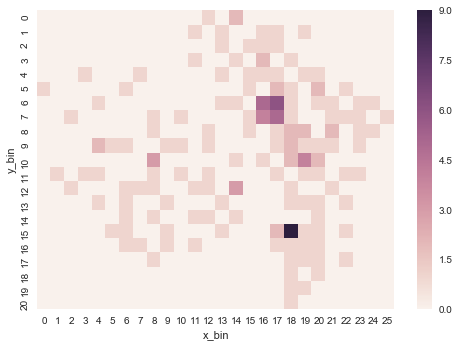

In [12]:
sns.heatmap(pd.crosstab(geodf["y_bin"], geodf["x_bin"]))

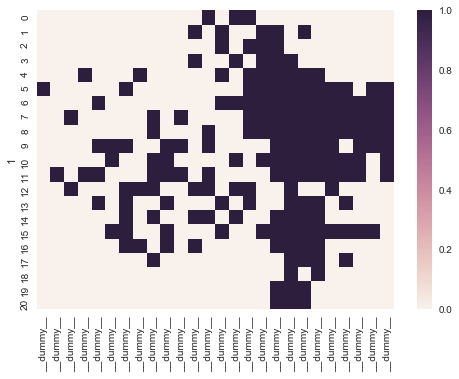

In [13]:
temp_df = pd.DataFrame([i.split('_') for i in coord_points.keys()]).astype(int)
sns.heatmap(pd.crosstab(temp_df[1], temp_df[0]))

### Step 5
Convert grid to hexmap SVG

In [14]:
geodf['hex_x'] = geodf['AC_NO'].apply(lambda x: point_position[x.split("_")[-1]]["x_bin"])
geodf['hex_y'] = geodf['AC_NO'].apply(lambda x: point_position[x.split("_")[-1]]["y_bin"])

In [15]:
ids = geodf.AC_NO.tolist()
colors = ["#eeeeee"]*len(ids)

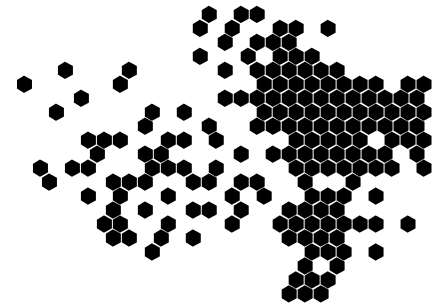

In [16]:
cg = Chorogrid(geodf, ids, colors, id_column="AC_NO")
cg.draw_hex()
cg.done(save_filename="gujarat_ac_hex.svg", show=True)